# $lambda=0.01$

# Import dependencies

In [1]:
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from PIL import Image
import warnings
import os
import random
import datetime

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

2021-11-20 09:04:21.364267: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/qc/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))

TensorFlow 2.4.1; Keras 2.4.0


In [3]:
tf.test.gpu_device_name()


2021-11-20 09:04:22.943614: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-20 09:04:22.946521: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-20 09:04:23.003060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 09:04:23.003943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 32

'/device:GPU:0'

# Define Parameters

In [6]:
BASE_PATH = "src_to_tar1/"
TAR_BASE_PATH = "./categorical-east/"
NUM_CLASSES = 4
im_height, im_width = 256, 256
test_ratio = 0.1
BATCH_SIZE = 8
NUM_EPOCHS = 50

# Read Dataset

In [7]:
# Extrac name of files
files = os.listdir(BASE_PATH)
tar_files = os.listdir(TAR_BASE_PATH)
files = [BASE_PATH + f for f in files]
# files = files[:800]
tar_files = [TAR_BASE_PATH + f for f in tar_files]
print("###SRC FILES###")
print(BASE_PATH)
print(len(files))
print("###TAR FILES###")
print(TAR_BASE_PATH)
print(len(tar_files))

###SRC FILES###
src_to_tar1/
1188
###TAR FILES###
./categorical-east/
425


In [8]:
random.seed(10)
random.shuffle(files)
random.shuffle(tar_files)
test_size = int(len(files) * test_ratio)

test_files = files[:test_size]
non_test_files = files[test_size:]

val_size = int(len(non_test_files) * test_ratio)
val_files = non_test_files[:val_size]
train_files = non_test_files[val_size:]

print("Train size:", len(train_files))
print("Validation size:", len(val_files))
print("Test size:", len(test_files))
print(train_files[0])


Train size: 963
Validation size: 107
Test size: 118
src_to_tar1/133.npy


# Data Generator

In [10]:
class DataGenerator(keras.utils.Sequence):
    'Generate data for keras'
    def __init__(self, image_paths, batch_size, augment, shuffle, normalize=False, gan=False,
                minimum=0, maximum=0):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.normalize = normalize
        self.minimum = minimum
        self.maximum = maximum
        self.gan = gan
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_paths) / self.batch_size))
  

    def on_epoch_end(self):
        'Updates indices after each epoch'
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
              np.random.shuffle(self.indices)
  
    def __getitem__(self, index):
        'Generate one batch of data'
        # select indices of data for next batch
        indices = self.indices[index*self.batch_size: (index+1)*self.batch_size]

        # select data and load images
        imgs_lbls = []
        for i in indices:
            img_lbl = np.load(self.image_paths[i])
            # img_lbl = np.moveaxis(img_lbl, 0, -1)
            imgs_lbls.append(img_lbl)

        # preprocess and augment data
        if self.augment:
            img_lbls = self.augmentor(imgs_lbls)
    
        images = []
        labels = []
        for img_lbl in imgs_lbls:
            if self.gan:
                image = img_lbl[..., :12]
                images.append(image)
                label = img_lbl[..., 12:]
                labels.append(label)
            else:
                image = img_lbl[:12, :, :]
                image = np.moveaxis(image, 0, -1)
                images.append(image)
                label = img_lbl[12:, :, :]
                label = np.moveaxis(label, 0, -1)
                labels.append(label)
        images = np.array(images, dtype=np.float32)
        if self.normalize:
            images = (images - self.minimum) / (self.maximum - self.minimum)
        elif self.gan:
            images = (images + 1) / 2
        return images, np.array(labels, dtype=np.float32)
  
    def augmentor(self, imgs_lbls):
        k = np.random.randint(0, 4)
        imgs_lbls = [np.rot90(img_lbl, axes=(0, 1), k=k) for img_lbl in imgs_lbls]

        if np.random.randint(0, 2) == 0:
            imgs_lbls = [np.fliplr(img_lbl) for img_lbl in imgs_lbls]
        if np.random.randint(0, 2) == 0:
            imgs_lbls = [np.flipud(img_lbl) for img_lbl in imgs_lbls]
    

        return imgs_lbls

# importing models from keras_unet_collection

In [11]:
from keras_unet_collection.keras_unet_collection import models

In [12]:
d_model, model = models.unet_2d((256, 256, 12), [16, 32, 32, 64], n_labels=NUM_CLASSES,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Softmax', 
                      batch_norm=True, pool='max', unpool='nearest', name='unet',
                      is_domain_adaptation=False, da_type='conv2d', da_kernels=[32, 16])

2021-11-20 09:05:23.335108: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-20 09:05:23.335264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 09:05:23.335731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-11-20 09:05:23.335765: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-20 09:05:23.335804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-20 09:05:23.335827: I tensorflow/stream_executor/platform

In [13]:
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 12 0                                            
__________________________________________________________________________________________________
unet_down0_0 (Conv2D)           (None, 256, 256, 16) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
unet_down0_0_bn (BatchNormaliza (None, 256, 256, 16) 64          unet_down0_0[0][0]               
__________________________________________________________________________________________________
unet_down0_0_activation (GELU)  (None, 256, 256, 16) 0           unet_down0_0_bn[0][0]            
_________________________________________________________________________________________

In [15]:
maximum, minimum = 14.733826, -49.208305

train_gen = DataGenerator(image_paths=train_files, batch_size=BATCH_SIZE,  augment=True, 
                          shuffle=True, normalize=False, gan=True, maximum=maximum, minimum=minimum)
val_gen = DataGenerator(image_paths=val_files, batch_size=BATCH_SIZE, augment=False, shuffle=False,
                        normalize=False, gan=True, maximum=maximum, minimum=minimum)
test_gen = DataGenerator(image_paths=test_files, batch_size=BATCH_SIZE, augment=False, shuffle=False,
                         normalize=False, gan=True, maximum=maximum, minimum=minimum)

tar_gen = DataGenerator(image_paths=tar_files, batch_size=BATCH_SIZE, augment=False, shuffle=False,
                         normalize=True, maximum=maximum, minimum=minimum)



In [16]:
def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(i, classSelectors) for i in np.arange(len(weightsList), dtype='int64')]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [17]:
other = 17749814 + 17766350 + 22149798
corn = 204516 + 172453 + 235173
cotton = 88734 + 26780 + 1677
rice = 10122026 + 6884977 + 7128782
total = other + corn + cotton + rice 

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_other = (1 / other) * (total / 2.0)
weight_for_corn = (1 / corn) * (total / 2.0)
weight_for_cotton = (1 / cotton) * (total / 2.0)
weight_for_rice = (1 / rice) * (total / 2.0)

class_weight = {0: weight_for_other, 1: weight_for_corn, 2: weight_for_cotton, 3: weight_for_rice}

print('Weight for class 0: {:.2f}'.format(weight_for_other))
print('Weight for class 1: {:.2f}'.format(weight_for_corn))
print('Weight for class 2: {:.2f}'.format(weight_for_cotton))
print('Weight for class 3: {:.2f}'.format(weight_for_rice))

weights = [weight_for_other, weight_for_corn, weight_for_cotton, weight_for_rice]

Weight for class 0: 0.72
Weight for class 1: 67.41
Weight for class 2: 352.12
Weight for class 3: 1.71


In [18]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-7,
    decay_steps=2000,
    decay_rate=0.9)
optimizer1 = keras.optimizers.Adam(learning_rate=lr_schedule)

In [19]:
model.compile(optimizer=optimizer1, 
              loss=weightedLoss(keras.losses.categorical_crossentropy, weights),
              metrics=['accuracy'])

In [20]:
checkpoint_filepath = 'EnCycGANUnetCheckpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [21]:
model.load_weights('UnetCheckpoint/checkpoint')

In [23]:
model.fit(train_gen, epochs=50, validation_data=val_gen, callbacks=[model_checkpoint_callback])

Epoch 1/50
120/120 [==============================] - 14s 115ms/step - loss: 4.4761 - accuracy: 0.6700 - val_loss: 4.0088 - val_accuracy: 0.6940
Epoch 2/50
120/120 [==============================] - 13s 109ms/step - loss: 4.4530 - accuracy: 0.6717 - val_loss: 4.3165 - val_accuracy: 0.6881
Epoch 3/50
120/120 [==============================] - 13s 106ms/step - loss: 4.4090 - accuracy: 0.6696 - val_loss: 4.4440 - val_accuracy: 0.6865
Epoch 4/50
120/120 [==============================] - 13s 105ms/step - loss: 4.3231 - accuracy: 0.6696 - val_loss: 4.4791 - val_accuracy: 0.6850
Epoch 5/50
120/120 [==============================] - 13s 106ms/step - loss: 4.2742 - accuracy: 0.6705 - val_loss: 4.4433 - val_accuracy: 0.6859
Epoch 6/50
120/120 [==============================] - 13s 105ms/step - loss: 4.9507 - accuracy: 0.6725 - val_loss: 4.4641 - val_accuracy: 0.6858
Epoch 7/50
120/120 [==============================] - 13s 106ms/step - loss: 4.2465 - accuracy: 0.6725 - val_loss: 4.4436 - val_ac

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [25]:
def plot_confusion_matrix(gen):
    preds = []
    trains = []
    for i, (image, label) in enumerate(gen):
        pred = model.predict(image)
        pred = np.argmax(pred, axis=-1)
        # pred = np.where(pred > 0.5, 1, 0)
        pred = pred.flatten()
        preds.append(pred)
        label = np.argmax(label, axis=-1)
        label = label.flatten()
        trains.append(label)

    trains = np.concatenate(trains)
    preds = np.concatenate(preds) 

    lin_preds = preds.flatten()

    lin_trains = trains.flatten()
    cm = confusion_matrix(lin_trains, lin_preds, normalize='true')
    cm_display = ConfusionMatrixDisplay(cm, display_labels=['others', 'Corn', 'Cotton', 'rice']).plot(cmap=plt.cm.Blues)
    plt.show()

In [26]:
model.load_weights(checkpoint_filepath)

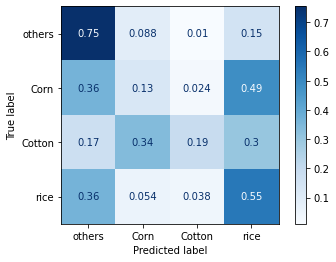

In [27]:
plot_confusion_matrix(train_gen)

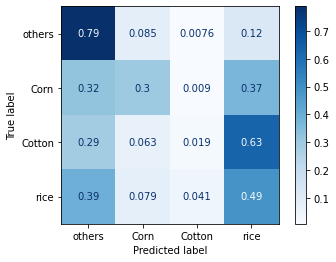

In [28]:
plot_confusion_matrix(val_gen)

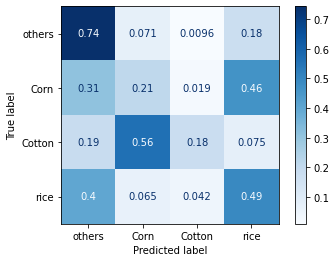

In [29]:
plot_confusion_matrix(test_gen)

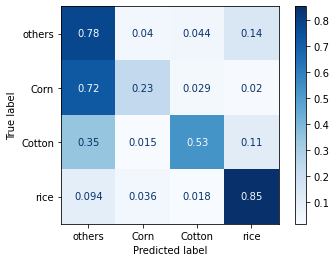

In [30]:
plot_confusion_matrix(tar_gen)

In [31]:
def plot_cnf_matrix(gen):
    # preds = np.zeros((len(gen), 65536, 1))
    # trains = np.zeros((len(gen), 65536, 1))
    preds = []
    trains = []
    for i, (image, label) in enumerate(gen):
        pred = model.predict(image)
        pred = np.argmax(pred, axis=-1)
        # pred = np.where(pred > 0.5, 1, 0)
        pred = pred.flatten()
        preds.append(pred)
        label = np.argmax(label, axis=-1)
        label = label.flatten()
        trains.append(label)

    trains = np.concatenate(trains)
    preds = np.concatenate(preds) 

    lin_preds = preds.flatten()

    lin_trains = trains.flatten()
    
    cm = tf.math.confusion_matrix(lin_trains, lin_preds)
#     cms = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
    
    # Get confusion matrix
#     cm = tf.confusion_matrix(tf.reshape(y_true, [-1]),
#                              tf.reshape(y_pred, [-1]))
    
    # Get precisions
    TP = tf.linalg.diag_part(cm)
    precisions = TP / tf.reduce_sum(cm, axis=0)
    
    # Get recalls
    TP = tf.linalg.diag_part(cm)
    recalls = TP / tf.reduce_sum(cm, axis=1)
    
    # Get F1s
    f1s = (2 * precisions * recalls) / (precisions + recalls)
    
    sns.heatmap(
        cm, annot=True,
        xticklabels=[0, 1],
        yticklabels=[0, 1])
    plt.xlabel("True")
    plt.ylabel("Predicted")
    
    plt.show()
    
#     return np.mean(f1s[1:])
    m = tf.keras.metrics.MeanIoU(num_classes=4)
    m.update_state(lin_trains, lin_preds)
    print(m.result().numpy())
    print(np.mean(f1s))

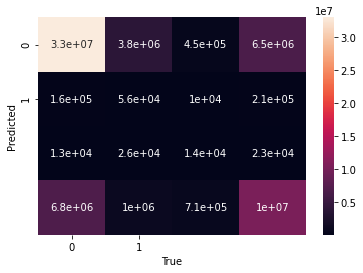

0.26857305
0.3512242321354505


In [32]:
plot_cnf_matrix(train_gen)

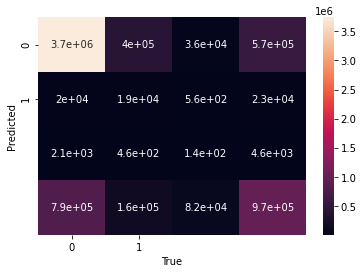

0.2695107
0.35227349175547196


In [33]:
plot_cnf_matrix(val_gen)

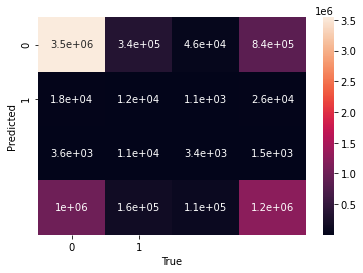

0.25475627
0.34382064648706123


In [34]:
plot_cnf_matrix(test_gen)

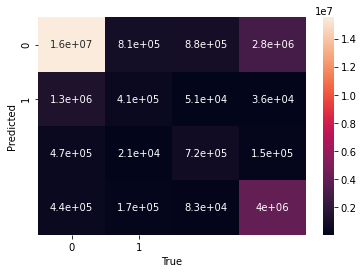

0.41745228
0.557394190945936


In [35]:
plot_cnf_matrix(tar_gen)

In [36]:
model.layers[27].name

'unet_down3_conv_1_activation'

In [37]:
from tensorflow.keras.models import Model

In [42]:
# Testing
mid_model = Model(inputs=[model.input], outputs=[model.layers[27].output])

In [55]:
maximum, minimum = 14.733826, -49.208305

train_gen = DataGenerator(image_paths=files, batch_size=400,  augment=True, 
                          shuffle=True, normalize=False, gan=True, maximum=maximum, minimum=minimum)


tar_gen = DataGenerator(image_paths=tar_files, batch_size=400, augment=False, shuffle=False,
                         normalize=True, maximum=maximum, minimum=minimum)


x_test, _ = train_gen[0]
x_tar, _ = tar_gen[0]
print(x_test.shape, x_tar.shape)
x = np.vstack((x_test, x_tar))
print(x.shape)

(400, 256, 256, 12) (400, 256, 256, 12)
(800, 256, 256, 12)


In [56]:
features = mid_model.predict(x)
print(features.shape)

2021-11-20 09:24:27.030658: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2516582400 exceeds 10% of free system memory.


(800, 32, 32, 64)


In [57]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [58]:
features = features.reshape(x.shape[0], -1)
features.shape

(800, 65536)

In [59]:
pca = PCA(n_components=20)
pca_result = pca.fit_transform(features)

In [60]:
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result)

/home/qc/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/qc/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.000s...
[t-SNE] Computed neighbors for 800 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 23.398387
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.462296
[t-SNE] KL divergence after 1000 iterations: 1.170461


In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
color_map = np.concatenate((np.ones(features.shape[0]//2), np.zeros(features.shape[0]//2)))
color_map.shape

(800,)

In [63]:
tsne_results.shape

(800, 2)

/home/qc/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

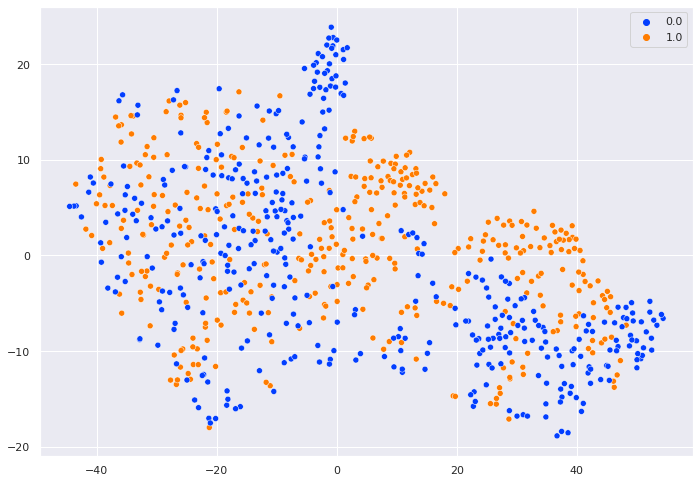

In [64]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=color_map, legend='full', palette=palette)